# Notebook 01: Bases de Datos Vectoriales - De Cero a Busqueda Semantica

---

**Curso:** AI Engineering | **Modulo:** RAG (Retrieval-Augmented Generation)

**Autor:** Equipo de AI Engineering

---

## Objetivos de Aprendizaje

Al finalizar este notebook, seras capaz de:

1. **Comprender** que son los embeddings y por que son fundamentales en AI Engineering.
2. **Generar** embeddings utilizando la API de OpenAI (`text-embedding-3-small`).
3. **Visualizar** el espacio vectorial de embeddings mediante PCA y heatmaps de similitud.
4. **Implementar** busqueda semantica usando ChromaDB como vector database.
5. **Aplicar** filtrado por metadata para acotar resultados de busqueda.
6. **Comparar** metricas de distancia (cosine, L2, inner product) y entender cuando usar cada una.
7. **Realizar** operaciones CRUD completas sobre una coleccion de vectores.
8. **Evaluar** distintas bases de datos vectoriales y elegir la adecuada para cada caso de uso.

---

> **Nota importante:** Este notebook asume que tienes configurada una API key de OpenAI en tu archivo `.env`.
> Si no la tienes, revisa la guia de setup del curso.

## 1. Que son los Embeddings?

Un **embedding** es una representacion numerica (vector) de un dato — texto, imagen, audio — en un espacio de alta dimension. La clave es que **textos con significado similar producen vectores cercanos** en ese espacio.

### Intuicion Visual

```
TEXTO                          VECTOR (espacio n-dimensional)
================================  ====================================
                                
"Politica de vacaciones"   -->  [0.12, -0.45, 0.78, ..., 0.33]  ──┐
                                                                    │ CERCANOS
"Dias libres del empleado" -->  [0.14, -0.42, 0.75, ..., 0.31]  ──┘
                                
                                                                    
"Deploy a produccion"      -->  [-0.67, 0.23, 0.11, ..., -0.89] ──┐
                                                                    │ CERCANOS  
"CI/CD pipeline"           -->  [-0.64, 0.25, 0.09, ..., -0.85] ──┘
                                
                                
         ┌─────────────────────────────────────────┐
         │     Espacio de Embeddings (2D aprox)     │
         │                                         │
         │   * vacaciones                          │
         │     * dias libres      LEJOS            │
         │                     <--------->         │
         │                          * deploy       │
         │                            * CI/CD      │
         │                                         │
         └─────────────────────────────────────────┘
```

### Por que importan?

- **Busqueda semantica:** No buscamos por palabras exactas, sino por *significado*.
- **RAG:** Recuperamos documentos relevantes para darle contexto a un LLM.
- **Clustering:** Agrupamos documentos similares automaticamente.
- **Recomendacion:** Encontramos items similares a lo que le gusto al usuario.

### Dimensionalidad

| Modelo                    | Dimensiones | Proveedor |
|---------------------------|-------------|------------|
| `text-embedding-3-small`  | 1536        | OpenAI     |
| `text-embedding-3-large`  | 3072        | OpenAI     |
| `text-embedding-ada-002`  | 1536        | OpenAI     |
| `all-MiniLM-L6-v2`       | 384         | HuggingFace|

En este notebook usaremos `text-embedding-3-small` por su excelente balance entre costo, velocidad y calidad.

## 2. Setup del Entorno

In [ ]:
# ==============================================================================
# SETUP: Importacion de librerias y configuracion del entorno
# ==============================================================================

# --- Librerias principales ---
import openai
from openai import OpenAI
import chromadb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Carga de variables de entorno ---
from dotenv import load_dotenv
import os

load_dotenv()

# --- Configuracion de matplotlib ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# --- Inicializar cliente de OpenAI ---
client = OpenAI()  

# --- Verificacion ---
print("=" * 60)
print("SETUP COMPLETADO")
print("=" * 60)
print(f"OpenAI version:    {openai.__version__}")
print(f"ChromaDB version:  {chromadb.__version__}")
print(f"NumPy version:     {np.__version__}")
print(f"API Key cargada:   {'Si' if os.getenv('OPENAI_API_KEY') else 'No (REVISAR .env)'}")
print("=" * 60)

SETUP COMPLETADO
OpenAI version:    2.16.0
ChromaDB version:  1.5.0
NumPy version:     2.4.2
API Key cargada:   Si


## 3. Crear Embeddings con OpenAI

Vamos a construir una funcion helper que nos permita generar embeddings de forma sencilla. Esta funcion sera la base para todo lo que hagamos en el notebook.

### La API de Embeddings

```
INPUT:  ["texto 1", "texto 2", ...]   (lista de strings)
                    │
                    ▼
         ┌─────────────────┐
         │  OpenAI API     │
         │  /embeddings    │
         └─────────────────┘
                    │
                    ▼
OUTPUT: [[0.12, -0.45, ...], [0.78, 0.33, ...]]  (lista de vectores)
```

In [2]:
# ==============================================================================
# FUNCION HELPER: Generar embeddings con OpenAI
# ==============================================================================

def get_embeddings(texts: list[str], model: str = "text-embedding-3-small") -> list[list[float]]:
    """
    Genera embeddings para una lista de textos usando la API de OpenAI.
    
    Args:
        texts: Lista de strings a convertir en embeddings.
        model: Modelo de embeddings a usar (default: text-embedding-3-small).
    
    Returns:
        Lista de vectores (cada uno es una lista de floats).
    """
    # Llamada a la API de OpenAI
    response = client.embeddings.create(
        input=texts,
        model=model
    )
    
    # Extraemos los vectores de la respuesta
    embeddings = [item.embedding for item in response.data]
    
    return embeddings


# --- Verificacion rapida ---
test_embedding = get_embeddings(["Esto es una prueba"])
print(f"Funcion get_embeddings funcionando correctamente.")
print(f"Dimensiones del vector: {len(test_embedding[0])}")

Funcion get_embeddings funcionando correctamente.
Dimensiones del vector: 1536


In [3]:
# ==============================================================================
# CREAR EMBEDDINGS: 10 oraciones diversas (RRHH y Tech)
# ==============================================================================

# Definimos las oraciones organizadas por dominio
oraciones_rrhh = [
    "La politica de vacaciones otorga 15 dias habiles al anio.",               # 0
    "El proceso de onboarding para nuevos empleados dura dos semanas.",         # 1
    "Las evaluaciones de desempenio se realizan cada seis meses.",              # 2
    "El beneficio de home office aplica tres dias por semana.",                 # 3
    "Los aumentos salariales se definen en la revision anual de compensaciones." # 4
]

oraciones_tech = [
    "El deploy a produccion se hace mediante el pipeline de CI/CD en GitHub Actions.",  # 5
    "Usamos Docker y Kubernetes para orquestar los microservicios.",                     # 6
    "La base de datos principal es PostgreSQL con replicas de lectura.",                 # 7
    "El monitoreo de la aplicacion se realiza con Datadog y PagerDuty.",                # 8
    "Las pruebas unitarias deben tener al menos 80 por ciento de coverage."             # 9
]

# Lista completa de oraciones
todas_las_oraciones = oraciones_rrhh + oraciones_tech

# Etiquetas para cada oracion (para visualizacion)
etiquetas = [
    "Vacaciones", "Onboarding", "Evaluaciones", "Home office", "Salarios",
    "Deploy/CI-CD", "Docker/K8s", "PostgreSQL", "Monitoreo", "Testing"
]

# Dominio de cada oracion
dominios = ["rrhh"] * 5 + ["tech"] * 5

# --- Generar embeddings ---
print("Generando embeddings para 10 oraciones...")
embeddings = get_embeddings(todas_las_oraciones)
print(f"Embeddings generados exitosamente.\n")

# --- Mostrar resultados ---
print(f"{'#':<4} {'Etiqueta':<16} {'Dominio':<8} {'Dims':<6} {'Primeros 5 valores'}")
print("-" * 80)

for i, (etiqueta, dominio, emb) in enumerate(zip(etiquetas, dominios, embeddings)):
    primeros_5 = [f"{v:+.4f}" for v in emb[:5]]
    print(f"{i:<4} {etiqueta:<16} {dominio:<8} {len(emb):<6} {primeros_5}")

Generando embeddings para 10 oraciones...
Embeddings generados exitosamente.

#    Etiqueta         Dominio  Dims   Primeros 5 valores
--------------------------------------------------------------------------------
0    Vacaciones       rrhh     1536   ['-0.0041', '+0.0491', '+0.0229', '+0.0312', '-0.0094']
1    Onboarding       rrhh     1536   ['-0.0108', '+0.0453', '+0.0339', '-0.0148', '-0.0325']
2    Evaluaciones     rrhh     1536   ['-0.0061', '+0.0642', '+0.0857', '+0.0039', '+0.0226']
3    Home office      rrhh     1536   ['-0.0250', '+0.0287', '+0.0810', '+0.0041', '+0.0333']
4    Salarios         rrhh     1536   ['-0.0062', '+0.0504', '+0.0966', '-0.0027', '-0.0172']
5    Deploy/CI-CD     tech     1536   ['+0.0118', '-0.0026', '+0.0466', '-0.0058', '-0.0106']
6    Docker/K8s       tech     1536   ['+0.0032', '+0.0013', '+0.0408', '-0.0233', '+0.0284']
7    PostgreSQL       tech     1536   ['+0.0026', '+0.0336', '+0.0788', '-0.0327', '+0.0122']
8    Monitoreo        tech     1

## 4. Visualizar el Espacio de Embeddings

Los embeddings viven en un espacio de 1536 dimensiones — imposible de visualizar directamente. Usamos **PCA (Principal Component Analysis)** para reducir a 2 dimensiones manteniendo la mayor varianza posible.

### Que hace PCA?

```
Espacio original (1536D)    PCA     Espacio reducido (2D)
┌─────────────────────┐   ------>  ┌──────────────────┐
│ [0.12, -0.45, ...]  │           │ [1.23, -0.67]    │
│ (1536 valores)      │           │ (2 valores)      │
└─────────────────────┘           └──────────────────┘
```

**Advertencia:** PCA es una *aproximacion*. La estructura real del espacio es mucho mas rica. Pero es util para obtener una intuicion visual.

Shape del array de embeddings: (10, 1536)
Varianza explicada por cada componente: [0.2398273  0.12958025]
Varianza total explicada: 36.94%



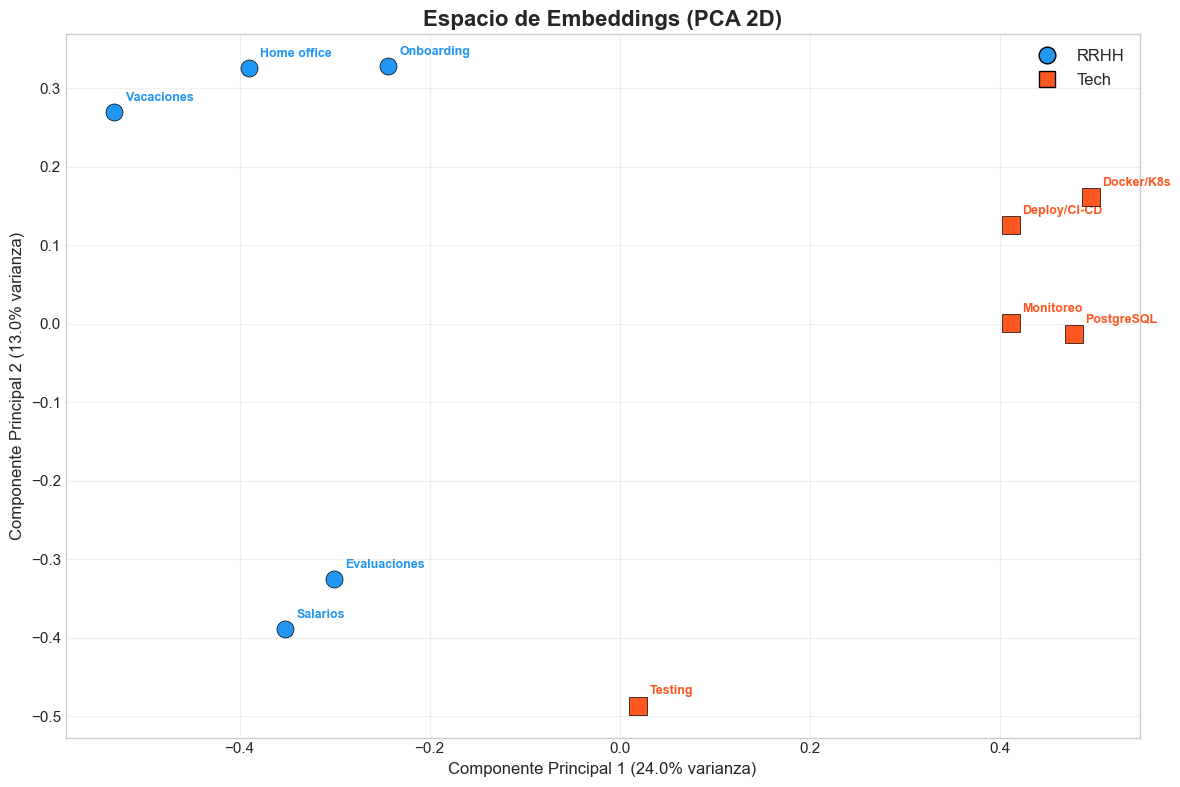


Observa como los temas de RRHH tienden a agruparse juntos,
separados de los temas de Tech. Esa es la magia de los embeddings.


In [4]:
# ==============================================================================
# VISUALIZACION: Reduccion con PCA y grafico 2D
# ==============================================================================

# Convertir embeddings a numpy array para PCA
embeddings_array = np.array(embeddings)
print(f"Shape del array de embeddings: {embeddings_array.shape}")

# Aplicar PCA para reducir de 1536D a 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_):.2%}\n")

# --- Crear el grafico ---
fig, ax = plt.subplots(figsize=(12, 8))

# Colores por dominio
colores = {'rrhh': '#2196F3', 'tech': '#FF5722'}  # Azul para RRHH, Naranja para Tech
marcadores = {'rrhh': 'o', 'tech': 's'}           # Circulo para RRHH, Cuadrado para Tech

# Graficar cada punto
for i, (x, y) in enumerate(embeddings_2d):
    dominio = dominios[i]
    ax.scatter(
        x, y,
        c=colores[dominio],
        marker=marcadores[dominio],
        s=150,
        edgecolors='black',
        linewidths=0.5,
        zorder=5
    )
    # Agregar etiqueta con un pequenio offset
    ax.annotate(
        etiquetas[i],
        (x, y),
        textcoords="offset points",
        xytext=(8, 8),
        fontsize=9,
        fontweight='bold',
        color=colores[dominio]
    )

# Leyenda manual
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2196F3',
           markersize=12, label='RRHH', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#FF5722',
           markersize=12, label='Tech', markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Configuracion del grafico
ax.set_title('Espacio de Embeddings (PCA 2D)', fontsize=16, fontweight='bold')
ax.set_xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)', fontsize=12)
ax.set_ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObserva como los temas de RRHH tienden a agruparse juntos,")
print("separados de los temas de Tech. Esa es la magia de los embeddings.")

## 5. Similitud Coseno Manual

La **similitud coseno** mide el angulo entre dos vectores, ignorando su magnitud. Es la metrica mas usada en busqueda semantica.

### Formula

```
                    A . B            Σ(ai * bi)
cos(θ) = ──────────────────── = ─────────────────────
             ||A|| * ||B||       √Σ(ai²) * √Σ(bi²)
```

### Interpretacion

| Valor          | Significado                  |
|----------------|------------------------------|
| `1.0`          | Vectores identicos           |
| `0.7 - 0.99`   | Muy similares               |
| `0.3 - 0.7`    | Algo relacionados           |
| `0.0`          | Sin relacion (ortogonales)  |
| `-1.0`         | Completamente opuestos      |

> **Nota:** Con embeddings de OpenAI, los valores tipicamente estan entre 0.0 y 1.0 ya que los vectores estan normalizados.

In [5]:
# ==============================================================================
# SIMILITUD COSENO: Implementacion manual con NumPy
# ==============================================================================

def cosine_similarity(a: list[float], b: list[float]) -> float:
    """
    Calcula la similitud coseno entre dos vectores.
    
    Args:
        a: Primer vector.
        b: Segundo vector.
    
    Returns:
        Similitud coseno (float entre -1 y 1).
    """
    a = np.array(a)
    b = np.array(b)
    
    # Producto punto
    dot_product = np.dot(a, b)
    
    # Normas (magnitudes)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # Evitar division por cero
    if norm_a == 0 or norm_b == 0:
        return 0.0
    
    return dot_product / (norm_a * norm_b)


# --- Definir pares de comparacion ---
pares_comparacion = [
    # (indice_a, indice_b, descripcion)
    (0, 3, "Vacaciones vs Home office (ambos RRHH)"),
    (5, 6, "Deploy/CI-CD vs Docker/K8s (ambos Tech)"),
    (0, 1, "Vacaciones vs Onboarding (ambos RRHH)"),
    (5, 8, "Deploy/CI-CD vs Monitoreo (ambos Tech)"),
    (0, 5, "Vacaciones vs Deploy (RRHH vs Tech)"),
    (1, 7, "Onboarding vs PostgreSQL (RRHH vs Tech)"),
    (4, 9, "Salarios vs Testing (RRHH vs Tech)"),
    (2, 8, "Evaluaciones vs Monitoreo (RRHH vs Tech)"),
]

# --- Calcular y mostrar resultados ---
print(f"{'Comparacion':<50} {'Similitud':>10} {'Interpretacion':>16}")
print("=" * 80)

for idx_a, idx_b, descripcion in pares_comparacion:
    sim = cosine_similarity(embeddings[idx_a], embeddings[idx_b])
    
    # Interpretar el resultado
    if sim >= 0.7:
        interpretacion = "Muy similar"
    elif sim >= 0.4:
        interpretacion = "Relacionado"
    else:
        interpretacion = "Poco similar"
    
    # Barra visual proporcional
    barra = "█" * int(sim * 20)
    
    print(f"{descripcion:<50} {sim:>10.4f} {interpretacion:>16}  {barra}")

print("\n" + "=" * 80)
print("Observa: las comparaciones dentro del mismo dominio tienen mayor similitud.")
print("Las comparaciones entre dominios distintos (RRHH vs Tech) son mas bajas.")

Comparacion                                         Similitud   Interpretacion
Vacaciones vs Home office (ambos RRHH)                 0.5063      Relacionado  ██████████
Deploy/CI-CD vs Docker/K8s (ambos Tech)                0.4817      Relacionado  █████████
Vacaciones vs Onboarding (ambos RRHH)                  0.3393     Poco similar  ██████
Deploy/CI-CD vs Monitoreo (ambos Tech)                 0.4939      Relacionado  █████████
Vacaciones vs Deploy (RRHH vs Tech)                    0.1693     Poco similar  ███
Onboarding vs PostgreSQL (RRHH vs Tech)                0.1671     Poco similar  ███
Salarios vs Testing (RRHH vs Tech)                     0.2488     Poco similar  ████
Evaluaciones vs Monitoreo (RRHH vs Tech)               0.3506     Poco similar  ███████

Observa: las comparaciones dentro del mismo dominio tienen mayor similitud.
Las comparaciones entre dominios distintos (RRHH vs Tech) son mas bajas.


## 6. Introduccion a ChromaDB

**ChromaDB** es una base de datos vectorial open-source, disenada para ser simple de usar y perfecta para prototipos y aplicaciones de mediana escala.

### Conceptos Clave

```
┌─────────────────────────────────────────────────┐
│                   ChromaDB                       │
│                                                  │
│  ┌──────────────────────────────────────────┐   │
│  │         Collection: "novatech_docs"       │   │
│  │                                           │   │
│  │  ID: "doc_001"                            │   │
│  │  Document: "La politica de vacaciones..."  │   │
│  │  Metadata: {domain: "rrhh", section: ...}  │   │
│  │  Embedding: [0.12, -0.45, ...]             │   │
│  │                                           │   │
│  │  ID: "doc_002"                            │   │
│  │  Document: "El proceso de deploy..."       │   │
│  │  Metadata: {domain: "tech", section: ...}  │   │
│  │  Embedding: [-0.67, 0.23, ...]             │   │
│  │  ...                                      │   │
│  └──────────────────────────────────────────┘   │
└─────────────────────────────────────────────────┘
```

### Flujo de trabajo

1. **Crear cliente** → Conexion a ChromaDB (en memoria o persistente).
2. **Crear coleccion** → Define la metrica de distancia.
3. **Agregar documentos** → ChromaDB genera embeddings automaticamente (o los provees tu).
4. **Consultar** → Buscar documentos similares a un query.

In [6]:
# ==============================================================================
# CHROMADB: Creacion del cliente y la coleccion
# ==============================================================================

# Crear cliente en memoria (ephemeral - para desarrollo y prototipado)
chroma_client = chromadb.Client()

# Crear (o obtener si ya existe) una coleccion con distancia coseno
collection = chroma_client.get_or_create_collection(
    name="novatech_docs",
    metadata={"hnsw:space": "cosine"}  # Metrica de distancia: cosine
)

print(f"Coleccion creada: '{collection.name}'")
print(f"Metrica de distancia: cosine")
print(f"Documentos actuales: {collection.count()}")

Coleccion creada: 'novatech_docs'
Metrica de distancia: cosine
Documentos actuales: 0


In [7]:
# ==============================================================================
# CHROMADB: Agregar documentos de la empresa ficticia NovaTech
# ==============================================================================

# Documentos de RRHH de NovaTech
documentos_rrhh = [
    "NovaTech otorga 15 dias habiles de vacaciones al anio. Despues de 3 anios de antiguedad, se suman 2 dias adicionales por anio.",
    "El proceso de onboarding en NovaTech dura 2 semanas e incluye sesiones con cada equipo, asignacion de buddy y configuracion de herramientas.",
    "Las evaluaciones de desempenio en NovaTech se realizan semestralmente usando el framework de competencias OKR.",
    "NovaTech ofrece modalidad hibrida: 3 dias de home office y 2 dias presenciales en la oficina de Buenos Aires.",
    "Los ajustes salariales en NovaTech se revisan cada enero en base a desempenio, inflacion y bandas salariales del mercado.",
    "NovaTech ofrece un plan de salud prepaga para el empleado y grupo familiar directo.",
    "Las licencias por enfermedad en NovaTech requieren certificado medico a partir del segundo dia consecutivo.",
    "NovaTech tiene un programa de referidos: si recomendas a alguien y es contratado, recibis un bono de USD 500."
]

# Documentos de Tech de NovaTech
documentos_tech = [
    "El deploy a produccion en NovaTech se realiza mediante GitHub Actions. Todo merge a main dispara el pipeline de CI/CD automaticamente.",
    "NovaTech usa Docker para containerizar servicios y Kubernetes (EKS) para la orquestacion en AWS.",
    "La base de datos principal de NovaTech es PostgreSQL 15 en RDS, con replicas de lectura en us-east-1.",
    "El monitoreo en NovaTech se hace con Datadog para metricas, Sentry para errores y PagerDuty para alertas on-call.",
    "NovaTech exige un minimo de 80 por ciento de code coverage en tests unitarios. Usamos pytest como framework de testing.",
    "El versionado de APIs en NovaTech sigue el patron /api/v1/, /api/v2/. Toda API nueva requiere documentacion en Swagger.",
    "Los secrets y credenciales en NovaTech se gestionan con AWS Secrets Manager. Esta prohibido hardcodear secrets en el codigo.",
    "NovaTech usa Redis como cache layer para sesiones de usuario y datos frecuentemente consultados. TTL por defecto: 1 hora."
]

# Combinar todos los documentos
todos_los_documentos = documentos_rrhh + documentos_tech

# Generar IDs unicos
ids = [f"doc_{i:03d}" for i in range(len(todos_los_documentos))]

# Crear metadata para cada documento
secciones_rrhh = [
    "vacaciones", "onboarding", "evaluaciones", "modalidad_trabajo",
    "compensaciones", "beneficios_salud", "licencias", "programa_referidos"
]
secciones_tech = [
    "deploy_cicd", "infraestructura", "base_datos", "monitoreo",
    "testing", "apis", "seguridad", "cache"
]

metadatas = []
for i, seccion in enumerate(secciones_rrhh):
    metadatas.append({"domain": "rrhh", "section": seccion, "company": "NovaTech"})
for i, seccion in enumerate(secciones_tech):
    metadatas.append({"domain": "tech", "section": seccion, "company": "NovaTech"})

# --- Agregar documentos a la coleccion ---
# ChromaDB genera embeddings automaticamente usando su modelo por defecto
collection.add(
    documents=todos_los_documentos,
    metadatas=metadatas,
    ids=ids
)

print(f"Documentos agregados exitosamente a la coleccion '{collection.name}'.")
print(f"Total de documentos: {collection.count()}")
print(f"\nDesglose:")
print(f"  - RRHH: {len(documentos_rrhh)} documentos")
print(f"  - Tech: {len(documentos_tech)} documentos")

# Mostrar los primeros 3 documentos como ejemplo
print(f"\n--- Ejemplo de documentos cargados ---")
for i in range(3):
    print(f"\n  ID: {ids[i]}")
    print(f"  Domain: {metadatas[i]['domain']}")
    print(f"  Section: {metadatas[i]['section']}")
    print(f"  Documento: {todos_los_documentos[i][:80]}...")

Documentos agregados exitosamente a la coleccion 'novatech_docs'.
Total de documentos: 16

Desglose:
  - RRHH: 8 documentos
  - Tech: 8 documentos

--- Ejemplo de documentos cargados ---

  ID: doc_000
  Domain: rrhh
  Section: vacaciones
  Documento: NovaTech otorga 15 dias habiles de vacaciones al anio. Despues de 3 anios de ant...

  ID: doc_001
  Domain: rrhh
  Section: onboarding
  Documento: El proceso de onboarding en NovaTech dura 2 semanas e incluye sesiones con cada ...

  ID: doc_002
  Domain: rrhh
  Section: evaluaciones
  Documento: Las evaluaciones de desempenio en NovaTech se realizan semestralmente usando el ...


## 7. Busqueda por Similitud

Ahora viene lo interesante: vamos a **buscar documentos usando lenguaje natural**. No necesitamos que la query contenga las mismas palabras que el documento — buscamos por *significado*.

### Como funciona?

```
Query: "cuantos dias de vacaciones tengo?"
           │
           ▼
    [embedding del query]
           │
           ▼
    Comparar con TODOS los embeddings de la coleccion
           │
           ▼
    Retornar los N documentos mas cercanos (menor distancia)
```

In [8]:
# ==============================================================================
# BUSQUEDA SEMANTICA: Query sobre vacaciones (deberia devolver docs de RRHH)
# ==============================================================================

def mostrar_resultados(resultados: dict, query: str) -> None:
    """Muestra los resultados de una query de ChromaDB de forma formateada."""
    print(f"\n{'=' * 80}")
    print(f"QUERY: \"{query}\"")
    print(f"{'=' * 80}")
    
    documentos = resultados['documents'][0]
    distancias = resultados['distances'][0]
    metadatas = resultados['metadatas'][0]
    ids = resultados['ids'][0]
    
    for i, (doc, dist, meta, doc_id) in enumerate(zip(documentos, distancias, metadatas, ids)):
        similitud = 1 - dist  # Para metrica cosine, distancia = 1 - similitud
        barra = "█" * int(similitud * 30)
        
        print(f"\n  [{i+1}] ID: {doc_id} | Domain: {meta['domain']} | Section: {meta['section']}")
        print(f"      Distancia: {dist:.4f} | Similitud: {similitud:.4f}  {barra}")
        print(f"      Documento: {doc[:100]}{'...' if len(doc) > 100 else ''}")


# --- Query 1: Vacaciones (tema de RRHH) ---
query_vacaciones = "cuantos dias de vacaciones tengo?"

resultados_vacaciones = collection.query(
    query_texts=[query_vacaciones],
    n_results=5
)

mostrar_resultados(resultados_vacaciones, query_vacaciones)


QUERY: "cuantos dias de vacaciones tengo?"

  [1] ID: doc_004 | Domain: rrhh | Section: compensaciones
      Distancia: 0.4808 | Similitud: 0.5192  ███████████████
      Documento: Los ajustes salariales en NovaTech se revisan cada enero en base a desempenio, inflacion y bandas sa...

  [2] ID: doc_000 | Domain: rrhh | Section: vacaciones
      Distancia: 0.5537 | Similitud: 0.4463  █████████████
      Documento: NovaTech otorga 15 dias habiles de vacaciones al anio. Despues de 3 anios de antiguedad, se suman 2 ...

  [3] ID: doc_007 | Domain: rrhh | Section: programa_referidos
      Distancia: 0.6135 | Similitud: 0.3865  ███████████
      Documento: NovaTech tiene un programa de referidos: si recomendas a alguien y es contratado, recibis un bono de...

  [4] ID: doc_006 | Domain: rrhh | Section: licencias
      Distancia: 0.6386 | Similitud: 0.3614  ██████████
      Documento: Las licencias por enfermedad en NovaTech requieren certificado medico a partir del segundo dia conse...

  [

In [9]:
# ==============================================================================
# BUSQUEDA SEMANTICA: Query sobre deploy (deberia devolver docs de Tech)
# ==============================================================================

# --- Query 2: Deploy a produccion (tema de Tech) ---
query_deploy = "como hago deploy a produccion?"

resultados_deploy = collection.query(
    query_texts=[query_deploy],
    n_results=5
)

mostrar_resultados(resultados_deploy, query_deploy)


QUERY: "como hago deploy a produccion?"

  [1] ID: doc_004 | Domain: rrhh | Section: compensaciones
      Distancia: 0.5087 | Similitud: 0.4913  ██████████████
      Documento: Los ajustes salariales en NovaTech se revisan cada enero en base a desempenio, inflacion y bandas sa...

  [2] ID: doc_005 | Domain: rrhh | Section: beneficios_salud
      Distancia: 0.5836 | Similitud: 0.4164  ████████████
      Documento: NovaTech ofrece un plan de salud prepaga para el empleado y grupo familiar directo.

  [3] ID: doc_003 | Domain: rrhh | Section: modalidad_trabajo
      Distancia: 0.6072 | Similitud: 0.3928  ███████████
      Documento: NovaTech ofrece modalidad hibrida: 3 dias de home office y 2 dias presenciales en la oficina de Buen...

  [4] ID: doc_008 | Domain: tech | Section: deploy_cicd
      Distancia: 0.6299 | Similitud: 0.3701  ███████████
      Documento: El deploy a produccion en NovaTech se realiza mediante GitHub Actions. Todo merge a main dispara el ...

  [5] ID: doc_001 | 

In [10]:
# ==============================================================================
# ANALISIS: Por que estos resultados tienen sentido?
# ==============================================================================

print("ANALISIS DE RESULTADOS")
print("=" * 60)
print()
print("Query 1: 'cuantos dias de vacaciones tengo?'")
print("-" * 60)
print("Los resultados principales son documentos de RRHH, con")
print("el documento de vacaciones en primer lugar. Esto es correcto")
print("porque la busqueda semantica entiende el SIGNIFICADO, no")
print("solo las palabras.")
print()
print("Query 2: 'como hago deploy a produccion?'")
print("-" * 60)
print("Los resultados principales son documentos de Tech, con")
print("el documento de CI/CD en primer lugar. Observa que incluso")
print("documentos de infraestructura (Docker/K8s) aparecen como")
print("relevantes, ya que estan semanticamente relacionados con deploy.")
print()
print("CONCLUSION: La busqueda semantica agrupa resultados por")
print("significado, no por coincidencia de palabras clave.")

ANALISIS DE RESULTADOS

Query 1: 'cuantos dias de vacaciones tengo?'
------------------------------------------------------------
Los resultados principales son documentos de RRHH, con
el documento de vacaciones en primer lugar. Esto es correcto
porque la busqueda semantica entiende el SIGNIFICADO, no
solo las palabras.

Query 2: 'como hago deploy a produccion?'
------------------------------------------------------------
Los resultados principales son documentos de Tech, con
el documento de CI/CD en primer lugar. Observa que incluso
documentos de infraestructura (Docker/K8s) aparecen como
relevantes, ya que estan semanticamente relacionados con deploy.

CONCLUSION: La busqueda semantica agrupa resultados por
significado, no por coincidencia de palabras clave.


## 8. Filtrado por Metadata

Ademas de la busqueda semantica, ChromaDB permite **filtrar por metadata**. Esto es crucial en aplicaciones reales donde necesitas acotar la busqueda a un subconjunto de documentos.

### Casos de uso tipicos

- Filtrar por **departamento** (solo documentos de RRHH)
- Filtrar por **fecha** (solo documentos actualizados este anio)
- Filtrar por **nivel de acceso** (solo documentos publicos)
- Filtrar por **idioma** (solo documentos en espaniol)

### Sintaxis de filtro en ChromaDB

```python
# Igualdad
where={"domain": "rrhh"}

# Operadores logicos
where={"$and": [{"domain": "tech"}, {"section": "deploy_cicd"}]}
where={"$or": [{"domain": "rrhh"}, {"section": "seguridad"}]}
```

In [11]:
# ==============================================================================
# FILTRADO POR METADATA: Comparar resultados con y sin filtro
# ==============================================================================

# Query ambigua que podria traer resultados de ambos dominios
query_ambigua = "cual es la politica de la empresa?"

# --- Sin filtro ---
print("\n" + "#" * 80)
print("# SIN FILTRO DE METADATA")
print("#" * 80)

resultados_sin_filtro = collection.query(
    query_texts=[query_ambigua],
    n_results=5
)
mostrar_resultados(resultados_sin_filtro, query_ambigua)

# --- Con filtro: solo RRHH ---
print("\n" + "#" * 80)
print("# CON FILTRO: domain = 'rrhh'")
print("#" * 80)

resultados_rrhh = collection.query(
    query_texts=[query_ambigua],
    n_results=5,
    where={"domain": "rrhh"}
)
mostrar_resultados(resultados_rrhh, query_ambigua + " [FILTRO: RRHH]")

# --- Con filtro: solo Tech ---
print("\n" + "#" * 80)
print("# CON FILTRO: domain = 'tech'")
print("#" * 80)

resultados_tech = collection.query(
    query_texts=[query_ambigua],
    n_results=5,
    where={"domain": "tech"}
)
mostrar_resultados(resultados_tech, query_ambigua + " [FILTRO: Tech]")


################################################################################
# SIN FILTRO DE METADATA
################################################################################

QUERY: "cual es la politica de la empresa?"

  [1] ID: doc_004 | Domain: rrhh | Section: compensaciones
      Distancia: 0.6320 | Similitud: 0.3680  ███████████
      Documento: Los ajustes salariales en NovaTech se revisan cada enero en base a desempenio, inflacion y bandas sa...

  [2] ID: doc_011 | Domain: tech | Section: monitoreo
      Distancia: 0.6948 | Similitud: 0.3052  █████████
      Documento: El monitoreo en NovaTech se hace con Datadog para metricas, Sentry para errores y PagerDuty para ale...

  [3] ID: doc_005 | Domain: rrhh | Section: beneficios_salud
      Distancia: 0.7082 | Similitud: 0.2918  ████████
      Documento: NovaTech ofrece un plan de salud prepaga para el empleado y grupo familiar directo.

  [4] ID: doc_003 | Domain: rrhh | Section: modalidad_trabajo
      Distancia: 0

In [12]:
# ==============================================================================
# FILTRADO POR METADATA: Discusion sobre cuando es critico
# ==============================================================================

print("CUANDO EL FILTRADO POR METADATA ES CRITICO")
print("=" * 60)
print()
print("1. MULTI-TENANCY (multiples clientes):")
print("   Si tu base de datos tiene documentos de diferentes")
print("   clientes, DEBES filtrar por tenant_id para evitar")
print("   que un cliente vea informacion de otro.")
print()
print("2. PERMISOS DE ACCESO:")
print("   Un empleado junior no deberia ver documentos")
print("   clasificados como 'confidencial' o 'directivos'.")
print()
print("3. CONTEXTO DEL CHAT:")
print("   Si el usuario esta en la seccion de RRHH del chatbot,")
print("   filtrar solo documentos de RRHH mejora la relevancia")
print("   y evita respuestas fuera de contexto.")
print()
print("4. VERSIONADO DE DOCUMENTOS:")
print("   Filtrar por 'version: latest' para no devolver")
print("   documentos desactualizados.")

CUANDO EL FILTRADO POR METADATA ES CRITICO

1. MULTI-TENANCY (multiples clientes):
   Si tu base de datos tiene documentos de diferentes
   clientes, DEBES filtrar por tenant_id para evitar
   que un cliente vea informacion de otro.

2. PERMISOS DE ACCESO:
   Un empleado junior no deberia ver documentos
   clasificados como 'confidencial' o 'directivos'.

3. CONTEXTO DEL CHAT:
   Si el usuario esta en la seccion de RRHH del chatbot,
   filtrar solo documentos de RRHH mejora la relevancia
   y evita respuestas fuera de contexto.

4. VERSIONADO DE DOCUMENTOS:
   Filtrar por 'version: latest' para no devolver
   documentos desactualizados.


## 9. Comparacion de Metricas de Distancia

ChromaDB soporta tres metricas de distancia. Entender las diferencias es importante para elegir la correcta.

### Las tres metricas

| Metrica           | Formula                          | Rango           | Mejor para                        |
|-------------------|----------------------------------|-----------------|------------------------------------|
| **Cosine**        | `1 - cos(A, B)`                  | `[0, 2]`        | Textos, cuando la magnitud no importa |
| **L2 (Euclidean)**| `√Σ(ai - bi)²`                  | `[0, ∞)`        | Datos donde la magnitud importa    |
| **IP (Inner Product)** | `-Σ(ai * bi)`               | `(-∞, ∞)`       | Vectores normalizados, ranking     |

> **Regla general:** Si usas embeddings de OpenAI (que estan normalizados), **cosine** e **IP** dan resultados equivalentes. **L2** puede dar un ordenamiento ligeramente diferente.

In [13]:
# ==============================================================================
# COMPARACION DE METRICAS: Crear 3 colecciones con diferentes distancias
# ==============================================================================

# Definir las metricas a comparar
metricas = {
    "cosine": "cosine",
    "l2": "l2",
    "ip": "ip"
}

colecciones_metricas = {}

for nombre, metrica in metricas.items():
    # Crear coleccion con la metrica especificada
    col = chroma_client.get_or_create_collection(
        name=f"novatech_{nombre}",
        metadata={"hnsw:space": metrica}
    )
    
    # Agregar los mismos documentos a cada coleccion
    col.add(
        documents=todos_los_documentos,
        metadatas=metadatas,
        ids=ids
    )
    
    colecciones_metricas[nombre] = col
    print(f"Coleccion '{col.name}' creada con metrica '{metrica}' - {col.count()} docs")

print(f"\n3 colecciones creadas con los mismos {len(todos_los_documentos)} documentos.")

Coleccion 'novatech_cosine' creada con metrica 'cosine' - 16 docs
Coleccion 'novatech_l2' creada con metrica 'l2' - 16 docs
Coleccion 'novatech_ip' creada con metrica 'ip' - 16 docs

3 colecciones creadas con los mismos 16 documentos.


In [14]:
# ==============================================================================
# COMPARACION DE METRICAS: Misma query, diferentes metricas
# ==============================================================================

query_comparacion = "como funciona el sistema de monitoreo?"
n_resultados = 5

print(f"QUERY: \"{query_comparacion}\"")
print(f"Comparando top {n_resultados} resultados con cada metrica:\n")

# Encabezado de la tabla
print(f"{'Rank':<6} {'COSINE':<30} {'L2':<30} {'IP':<30}")
print(f"{'':6} {'ID':10} {'Dist':>8} {'Sec':>10} {'ID':10} {'Dist':>8} {'Sec':>10} {'ID':10} {'Dist':>8} {'Sec':>10}")
print("-" * 96)

# Ejecutar la misma query en las 3 colecciones
resultados_por_metrica = {}
for nombre, col in colecciones_metricas.items():
    resultados_por_metrica[nombre] = col.query(
        query_texts=[query_comparacion],
        n_results=n_resultados
    )

# Mostrar resultados lado a lado
for rank in range(n_resultados):
    fila = f"{rank+1:<6} "
    for nombre in ["cosine", "l2", "ip"]:
        res = resultados_por_metrica[nombre]
        doc_id = res['ids'][0][rank]
        dist = res['distances'][0][rank]
        sec = res['metadatas'][0][rank]['section']
        fila += f"{doc_id:10} {dist:>8.4f} {sec:>10} "
    print(fila)

print("\n" + "=" * 96)
print("Observa: el ORDEN de los resultados puede variar entre metricas,")
print("pero los documentos mas relevantes tienden a aparecer en las 3.")
print("Con embeddings normalizados (OpenAI), cosine e IP son casi equivalentes.")

QUERY: "como funciona el sistema de monitoreo?"
Comparando top 5 resultados con cada metrica:

Rank   COSINE                         L2                             IP                            
       ID             Dist        Sec ID             Dist        Sec ID             Dist        Sec
------------------------------------------------------------------------------------------------
1      doc_011      0.4143  monitoreo doc_011      0.8286  monitoreo doc_011      0.4143  monitoreo 
2      doc_004      0.5568 compensaciones doc_004      1.1135 compensaciones doc_004      0.5568 compensaciones 
3      doc_015      0.6273      cache doc_015      1.2546      cache doc_015      0.6273      cache 
4      doc_005      0.6317 beneficios_salud doc_005      1.2633 beneficios_salud doc_005      0.6317 beneficios_salud 
5      doc_006      0.6517  licencias doc_006      1.3033  licencias doc_006      0.6517  licencias 

Observa: el ORDEN de los resultados puede variar entre metricas,
pero lo

## 10. Operaciones CRUD

Una base de datos vectorial no solo sirve para buscar. Necesitamos poder **crear**, **leer**, **actualizar** y **eliminar** documentos.

```
C - Create  →  collection.add()
R - Read    →  collection.get()
U - Update  →  collection.update()
D - Delete  →  collection.delete()
```

In [15]:
# ==============================================================================
# CRUD: Operaciones completas sobre la coleccion
# ==============================================================================

print("OPERACIONES CRUD EN CHROMADB")
print("=" * 60)

# --- READ: Obtener documento por ID ---
print("\n1. READ - Obtener documento por ID")
print("-" * 40)

doc_obtenido = collection.get(
    ids=["doc_000"],
    include=["documents", "metadatas"]
)

print(f"   ID: {doc_obtenido['ids'][0]}")
print(f"   Metadata: {doc_obtenido['metadatas'][0]}")
print(f"   Documento: {doc_obtenido['documents'][0][:80]}...")

# --- COUNT: Contar documentos ---
print(f"\n   Total documentos en coleccion: {collection.count()}")

# --- UPDATE: Actualizar un documento ---
print("\n2. UPDATE - Actualizar documento doc_000")
print("-" * 40)

nuevo_texto = "NovaTech ahora otorga 20 dias habiles de vacaciones al anio (actualizado 2026). Despues de 2 anios de antiguedad, se suman 3 dias adicionales por anio."

collection.update(
    ids=["doc_000"],
    documents=[nuevo_texto],
    metadatas=[{"domain": "rrhh", "section": "vacaciones", "company": "NovaTech", "updated": "2026-01"}]
)

# Verificar el update
doc_actualizado = collection.get(
    ids=["doc_000"],
    include=["documents", "metadatas"]
)
print(f"   Documento actualizado: {doc_actualizado['documents'][0][:80]}...")
print(f"   Metadata actualizada: {doc_actualizado['metadatas'][0]}")

# --- DELETE: Eliminar un documento ---
print("\n3. DELETE - Eliminar documento doc_007")
print("-" * 40)

print(f"   Documentos antes de eliminar: {collection.count()}")

collection.delete(ids=["doc_007"])

print(f"   Documentos despues de eliminar: {collection.count()}")

# Verificar que ya no existe
doc_eliminado = collection.get(ids=["doc_007"])
print(f"   Documento doc_007 existe: {len(doc_eliminado['ids']) > 0}")

# --- GET: Obtener multiples documentos ---
print("\n4. GET - Obtener multiples documentos por ID")
print("-" * 40)

docs_multiples = collection.get(
    ids=["doc_000", "doc_005", "doc_010"],
    include=["documents", "metadatas"]
)

for doc_id, doc, meta in zip(docs_multiples['ids'], docs_multiples['documents'], docs_multiples['metadatas']):
    print(f"   {doc_id} [{meta['domain']}] -> {doc[:60]}...")

print(f"\n{'=' * 60}")
print(f"Estado final de la coleccion: {collection.count()} documentos")

OPERACIONES CRUD EN CHROMADB

1. READ - Obtener documento por ID
----------------------------------------
   ID: doc_000
   Metadata: {'company': 'NovaTech', 'domain': 'rrhh', 'section': 'vacaciones'}
   Documento: NovaTech otorga 15 dias habiles de vacaciones al anio. Despues de 3 anios de ant...

   Total documentos en coleccion: 16

2. UPDATE - Actualizar documento doc_000
----------------------------------------
   Documento actualizado: NovaTech ahora otorga 20 dias habiles de vacaciones al anio (actualizado 2026). ...
   Metadata actualizada: {'section': 'vacaciones', 'updated': '2026-01', 'company': 'NovaTech', 'domain': 'rrhh'}

3. DELETE - Eliminar documento doc_007
----------------------------------------
   Documentos antes de eliminar: 16
   Documentos despues de eliminar: 15
   Documento doc_007 existe: False

4. GET - Obtener multiples documentos por ID
----------------------------------------
   doc_000 [rrhh] -> NovaTech ahora otorga 20 dias habiles de vacaciones al ani

## 11. Visualizacion Avanzada: Heatmap de Similitud

Para entender la estructura de nuestro corpus de documentos, vamos a crear un **heatmap de similitud** que muestra que tan similar es cada par de documentos.

Calculando matriz de similitud para 15 documentos...
Shape de la matriz de similitud: (15, 15)


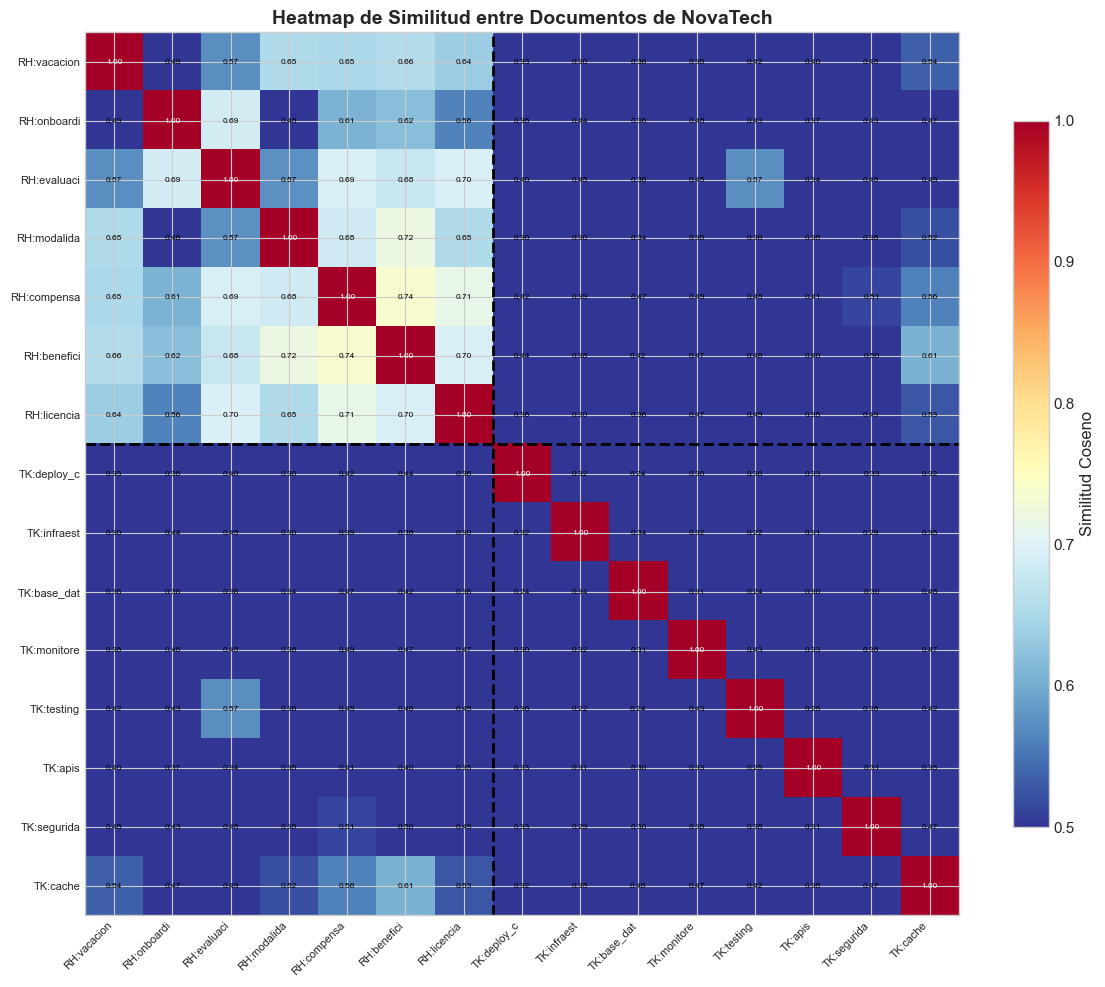


La linea punteada separa documentos de RRHH (arriba/izquierda)
de documentos Tech (abajo/derecha).
Observa que los bloques diagonales (mismo dominio) son mas claros
(mayor similitud) que los bloques cruzados (dominios diferentes).


In [16]:
# ==============================================================================
# HEATMAP DE SIMILITUD: Matriz de similitud entre todos los documentos
# ==============================================================================

# Obtener todos los documentos de la coleccion
todos_docs = collection.get(
    include=["documents", "metadatas", "embeddings"]
)

n_docs = len(todos_docs['ids'])
print(f"Calculando matriz de similitud para {n_docs} documentos...")

# Obtener embeddings (ChromaDB los genera internamente)
# Usamos los embeddings almacenados en ChromaDB
doc_embeddings = np.array(todos_docs['embeddings'])

# Calcular la matriz de similitud coseno
# Para vectores normalizados: similitud = producto punto
# Forma general: sim(a, b) = (a . b) / (||a|| * ||b||)
normas = np.linalg.norm(doc_embeddings, axis=1, keepdims=True)
embeddings_normalizados = doc_embeddings / normas
matriz_similitud = np.dot(embeddings_normalizados, embeddings_normalizados.T)

print(f"Shape de la matriz de similitud: {matriz_similitud.shape}")

# Crear etiquetas abreviadas para el heatmap
etiquetas_abreviadas = []
for doc_id, meta in zip(todos_docs['ids'], todos_docs['metadatas']):
    prefijo = "RH" if meta['domain'] == 'rrhh' else "TK"
    seccion = meta['section'][:8]
    etiquetas_abreviadas.append(f"{prefijo}:{seccion}")

# --- Crear el heatmap ---
fig, ax = plt.subplots(figsize=(12, 10))

# Graficar la matriz con imshow
im = ax.imshow(matriz_similitud, cmap='RdYlBu_r', vmin=0.5, vmax=1.0, aspect='auto')

# Configurar ejes
ax.set_xticks(range(n_docs))
ax.set_yticks(range(n_docs))
ax.set_xticklabels(etiquetas_abreviadas, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(etiquetas_abreviadas, fontsize=8)

# Agregar valores numericos en cada celda
for i in range(n_docs):
    for j in range(n_docs):
        valor = matriz_similitud[i, j]
        color_texto = 'white' if valor > 0.85 else 'black'
        ax.text(j, i, f'{valor:.2f}', ha='center', va='center',
                fontsize=6, color=color_texto)

# Barra de color
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Similitud Coseno', fontsize=12)

# Titulo y formato
ax.set_title('Heatmap de Similitud entre Documentos de NovaTech', fontsize=14, fontweight='bold')

# Agregar lineas separadoras entre dominios RRHH y Tech
# Encontrar el indice donde cambia de RRHH a Tech
dominios_docs = [m['domain'] for m in todos_docs['metadatas']]
n_rrhh = sum(1 for d in dominios_docs if d == 'rrhh')

ax.axhline(y=n_rrhh - 0.5, color='black', linewidth=2, linestyle='--')
ax.axvline(x=n_rrhh - 0.5, color='black', linewidth=2, linestyle='--')

plt.tight_layout()
plt.show()

print("\nLa linea punteada separa documentos de RRHH (arriba/izquierda)")
print("de documentos Tech (abajo/derecha).")
print("Observa que los bloques diagonales (mismo dominio) son mas claros")
print("(mayor similitud) que los bloques cruzados (dominios diferentes).")

## 12. Comparativa de Bases de Datos Vectoriales

ChromaDB es excelente para prototipos y proyectos pequenios a medianos, pero existen muchas otras opciones. Aqui una comparativa para ayudarte a elegir.

### Tabla Comparativa

| Caracteristica       | ChromaDB       | FAISS           | Pinecone        | Weaviate        | Qdrant          | pgvector        |
|----------------------|----------------|-----------------|-----------------|-----------------|-----------------|------------------|
| **Tipo**             | Embedded DB    | Libreria        | Managed Cloud   | Self-hosted/Cloud| Self-hosted/Cloud| Extension PG    |
| **Open Source**      | Si             | Si              | No              | Si              | Si              | Si              |
| **Lenguaje**         | Python         | C++ (Python API)| API REST        | Go              | Rust            | C (PostgreSQL)  |
| **Persistencia**     | In-memory/Disco| In-memory       | Cloud           | Disco           | Disco           | PostgreSQL      |
| **Escalabilidad**    | Baja-Media     | Alta (single node)| Muy alta      | Alta            | Alta            | Media-Alta      |
| **Filtrado Metadata**| Si             | Limitado        | Si              | Si (GraphQL)    | Si (rico)       | Si (SQL!)       |
| **Setup**            | 1 linea        | Moderado        | API key         | Docker          | Docker/Cloud    | Extension PG    |
| **Mejor para**       | Prototipo, POC | Alta velocidad  | Produccion SaaS | Apps complejas  | Produccion alto rendimiento | Ya usas PostgreSQL |
| **Pricing**          | Gratis         | Gratis          | Freemium        | Gratis/Paid     | Gratis/Paid     | Gratis          |

### Cuando usar cada una?

- **ChromaDB:** Queres arrancar rapido, prototipar, o tu dataset es < 100K documentos. Ideal para este curso.
- **FAISS (Facebook AI):** Necesitas velocidad extrema en un solo nodo. Ideal para busqueda offline o batch.
- **Pinecone:** Queres un servicio managed sin preocuparte por infraestructura. Ideal para startups en produccion.
- **Weaviate:** Necesitas queries complejas con GraphQL y funcionalidades de ML integradas.
- **Qdrant:** Necesitas alto rendimiento con filtrado avanzado. Excelente para produccion on-premise.
- **pgvector:** Ya tenes PostgreSQL en tu stack y no queres agregar otra base de datos.

## 13. Errores Comunes

Despues de trabajar con cientos de estudiantes, estos son los errores mas frecuentes que vemos:

### Error 1: No normalizar los textos antes de generar embeddings

```python
# MAL: textos con whitespace inconsistente
textos = ["  Hola mundo  ", "Hola\n\nmundo", "HOLA MUNDO"]

# BIEN: limpiar antes de embeddear
textos = [t.strip().lower() for t in textos]
```

**Por que importa:** El modelo de embeddings es sensible a diferencias en formato. Un mismo texto con diferente whitespace puede producir embeddings ligeramente distintos.

---

### Error 2: No incluir metadata relevante desde el inicio

```python
# MAL: agregar documentos sin metadata
collection.add(documents=[...], ids=[...])

# BIEN: agregar metadata desde el inicio
collection.add(
    documents=[...],
    ids=[...],
    metadatas=[{"source": "...", "domain": "...", "date": "..."}]
)
```

**Por que importa:** Agregar metadata despues es costoso y propenso a errores. Pensalo como parte del schema desde el dia 1.

---

### Error 3: Chunks demasiado grandes o demasiado pequenios

```python
# MAL: embeddear un documento entero de 50 paginas
embedding = get_embeddings([documento_completo])  # Pierde precision semantica

# MAL: chunks de una sola oracion
chunks = documento.split(".")  # Pierde contexto

# BIEN: chunks de 200-500 tokens con overlap
chunks = chunk_text(documento, chunk_size=400, overlap=50)
```

**Por que importa:** Chunks muy grandes diluyen el significado. Chunks muy chicos pierden contexto. El chunking strategy es uno de los factores mas importantes en la calidad de un sistema RAG.

---

### Error 4: Confundir distancia con similitud

```python
# MAL: pensar que mayor distancia = mas similar
# En ChromaDB con cosine, menor distancia = mas similar

# Distancia coseno = 1 - similitud coseno
# distancia 0.1 → similitud 0.9 (MUY similar)
# distancia 0.8 → similitud 0.2 (poco similar)
```

**Por que importa:** Interpretar los resultados al reves lleva a seleccionar los documentos *menos* relevantes.

---

### Error 5: No considerar el costo de las llamadas a la API de embeddings

```python
# MAL: generar embeddings en cada request
for query in user_queries:
    emb = get_embeddings([query])  # $$ por cada query
    # ... buscar

# BIEN: cachear embeddings de documentos, solo generar embedding del query
# Los documentos se embeddean UNA VEZ y se almacenan en la vector DB
# Solo el query necesita embedding en runtime
```

**Por que importa:** `text-embedding-3-small` cuesta ~$0.02 por millon de tokens. Parece poco, pero a escala suma rapido si re-generas embeddings innecesariamente.

## 14. Checklist de Consolidacion

Antes de pasar al siguiente notebook, asegurate de poder responder estas preguntas:

- [ ] **1.** Que es un embedding y por que textos semanticamente similares producen vectores cercanos?

- [ ] **2.** Cual es la diferencia entre similitud coseno y distancia coseno? Si ChromaDB me devuelve una distancia de 0.15, la similitud es alta o baja?

- [ ] **3.** Por que el filtrado por metadata es critico en aplicaciones multi-tenant? Que podria pasar si no lo implementamos?

- [ ] **4.** Si tengo 1 millon de documentos y necesito busqueda semantica en produccion con alta disponibilidad, que base de datos vectorial elegirias y por que?

- [ ] **5.** Explica con tus palabras por que el tamanio del chunk afecta la calidad de la busqueda semantica. Que pasaria con chunks de 1 palabra? Y con chunks de 10,000 palabras?

---

### Siguiente Notebook

En el **Notebook 02** vamos a construir un sistema RAG completo, combinando lo que aprendimos aqui de vector databases con un LLM para generar respuestas contextualizadas.

---

*Fin del Notebook 01: Bases de Datos Vectoriales*